# Analyze pendulum data
Use this notebook to quickly test whether your pendulum data makes sense!

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Example file location
filename_example = 'data_pendulum_example/timer_output_31meas.dat'

## Data reader

In [3]:
# Read in data
def read_data(filename):
    dat = np.genfromtxt(filename, delimiter='\t', names=('n', 't_s'))
    return dat

## Read and plot the data

[(0.0, 31.0), (0.0, 232.5617)]

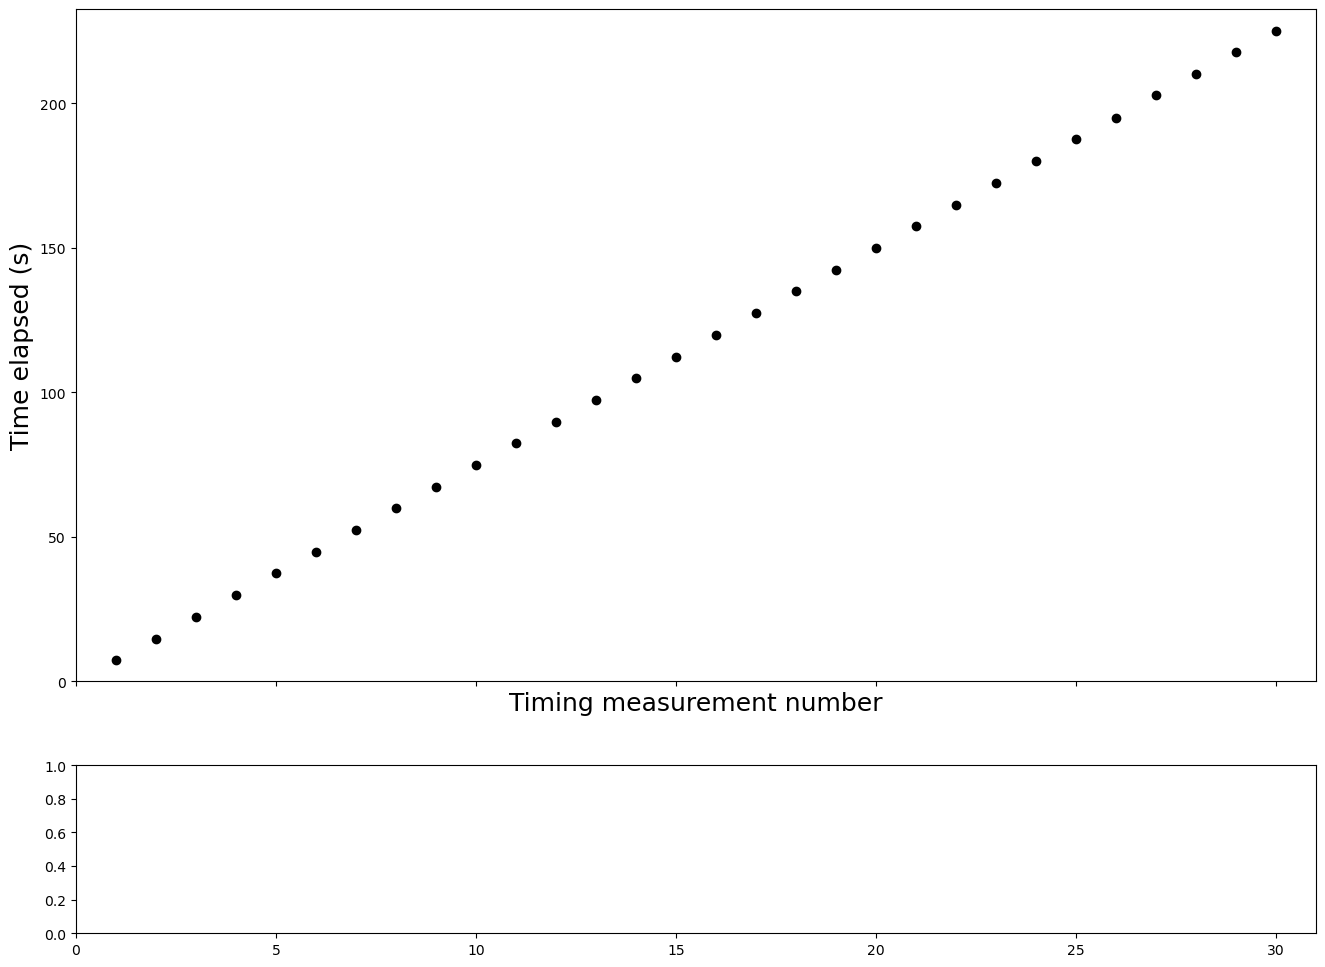

In [4]:
data_example = read_data(filename_example)
n, t = data_example['n'], data_example['t_s']

# Plotting
sig_t = 0.1     # Set your own values...
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 12), gridspec_kw={'height_ratios':[4,1]}, sharex=True)
ax[0].errorbar(n, t, yerr=sig_t, color='k', fmt='o')
ax[0].set_xlabel('Timing measurement number', fontsize=18)
ax[0].set_ylabel('Time elapsed (s)', fontsize=18)
ax[0].set(xlim=(0, n[-1]+np.ediff1d(n)[0]), ylim=(0, t[-1]+np.ediff1d(t)[0]))

# What to do next?

The reason for the (empty) plot below is, that though your data (hopefully) lies on a line, you're not able to see any smaller effects. However, if you plot the __residuals__ (the difference between your measurements and a fit to them), then you will much better be able to tell, if the data looks good. Also, it is from a historgram of the residuals, that you can determine, if your errors are Gaussian (or have any obvious outliers), and from the Standard Deviation what your (typical) uncertainty is.